In [1]:
%matplotlib inline

In [2]:
from tensorflow.python.keras.applications.vgg16 import VGG16

#不會用到既有的1000個類別輸出
#因此設定為:include_top=False

vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))


#注意觀察網路結構，沒有輸出層
vgg16.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten


def build_transfer_model(vgg16):
    
    #自定義後續的輸出層
    model = Sequential(vgg16.layers)

    #改變之前layer的trainable參數為False
    #這表示模型到目前為止都不訓練了
    for layer in model.layers:
        layer.trainable = False
        
    #增加一層Flatten
    model.add(Flatten())
    
    #增加一層Fully-connection層
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    #增加輸出層，輸出為1個類別
    model.add(Dense(1, activation='sigmoid'))
    
    return model


#將調整過剩下13層的VGG網路代入
model = build_transfer_model(vgg16)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#檢視新增的幾層

model.layers

In [5]:
#使用VGG模型現成的權重，並且套用到目前新增的圖片
#指定最佳化演算法來編譯這個新的模型
#學習率設定: 慢慢修正，調低一點

from tensorflow.python.keras.optimizers import SGD


model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [6]:
#檢視模型概要

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

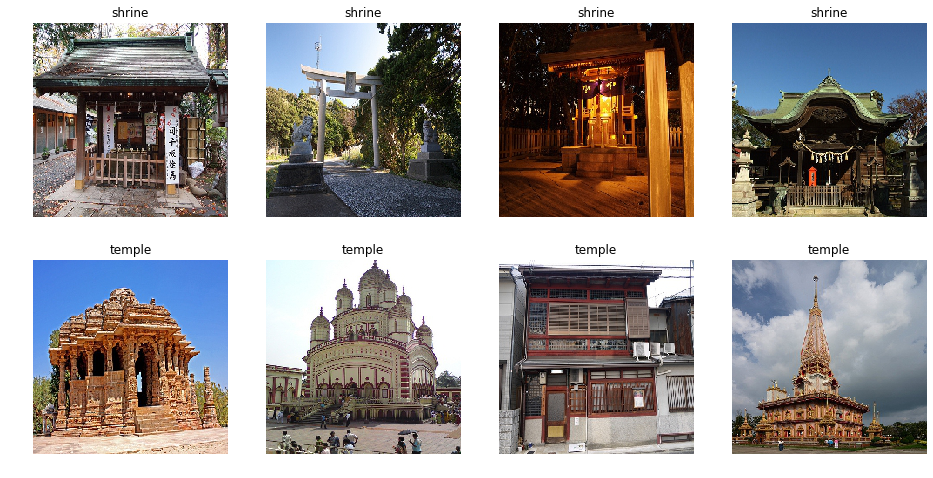

In [7]:
#顯示新圖片

from utils import show_train_samples


img_dir = 'img/shrine_temple'
show_train_samples(img_dir, classes=('shrine', 'temple'), seed=2)

In [8]:
#ImageDataGenerator用來產生多一些訓練圖片
#設定指定參數、調整尺度、圖片擴張

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import preprocess_input


idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [9]:
#新的訓練照片集

img_itr_train = idg_train.flow_from_directory(
    'img/shrine_temple/train', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

img_itr_validation = idg_train.flow_from_directory(
    'img/shrine_temple/validation', 
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [10]:
#建立新的模型建置所需要的資料夾
#以執行日當作名稱

import os
from datetime import datetime


model_dir = os.path.join(
    'models', 
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)  

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

model_dir: models\190613_1234


In [11]:
#儲存模型學習時的資訊

import json
import pickle


#深度學習網路層資訊
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

#新模型學習資訊
model_classes = os.path.join(model_dir, 'classes.pkl')
with open(model_classes, 'wb') as f:
    pickle.dump(img_itr_train.class_indices, f)

In [12]:
#學習批次
#學習的過程中，會經過幾個小批次

import math


batch_size = 16
steps_per_epoch = math.ceil(
    img_itr_train.samples/batch_size
)
validation_steps = math.ceil(
    img_itr_validation.samples/batch_size
)

In [13]:
#學習的過程中，以csv格式紀錄loss狀態
#透過callbacks方式進行

from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger


cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='loss', 
                     verbose=0,
                     save_best_only=False, 
                     save_weights_only=True, 
                     mode='auto', 
                     period=5
                     )


#最後畫圖的時候要讀取的資料
csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

In [34]:
#準備好以上模型學習資訊，便可開始
#callbacks會做兩件事:cp與csv

n_epoch = 30

#防止過擬合: early stoppping 
#monitor: 需要監視的值: val_loss，val_acc
#patience: 當early stop被激活，若發現loss沒有比上一個epoch下降，則經過patience個epoch後停止訓練
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_loss', patience=20, mode='auto')


history = model.fit_generator(
    img_itr_train, 
    steps_per_epoch=steps_per_epoch, 
    epochs=n_epoch,
    shuffle=True, 
    validation_data=img_itr_validation, 
    validation_steps=validation_steps,
    callbacks = [
                 cp, 
                 csv, 
                 #early_stopping
                ]
)

Epoch 1/30
38/38 [==============================] - 15s 395ms/step - loss: 0.2125 - acc: 0.9150 - val_loss: 0.1919 - val_acc: 0.9250
Epoch 2/30
38/38 [==============================] - 14s 365ms/step - loss: 0.2144 - acc: 0.9233 - val_loss: 0.1962 - val_acc: 0.9250
Epoch 3/30
38/38 [==============================] - 14s 362ms/step - loss: 0.1952 - acc: 0.9350 - val_loss: 0.1926 - val_acc: 0.9400
Epoch 4/30
38/38 [==============================] - 14s 356ms/step - loss: 0.1931 - acc: 0.9233 - val_loss: 0.1894 - val_acc: 0.9250
Epoch 5/30
38/38 [==============================] - 14s 357ms/step - loss: 0.1908 - acc: 0.9317 - val_loss: 0.1806 - val_acc: 0.9400
Epoch 6/30
38/38 [==============================] - 15s 398ms/step - loss: 0.2262 - acc: 0.9167 - val_loss: 0.2152 - val_acc: 0.9250
Epoch 7/30
38/38 [==============================] - 14s 367ms/step - loss: 0.2007 - acc: 0.9267 - val_loss: 0.2081 - val_acc: 0.9150
Epoch 8/30
38/38 [==============================] - 13s 354ms/step - 

In [35]:
from utils import load_random_imgs

test_data_dir = 'img/shrine_temple/test/unknown'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)

#處理測試的圖片
x_test_preproc= preprocess_input(x_test.copy())/255.

#預測
probs = model.predict(x_test_preproc)

probs

array([[0.00326315],
       [0.12411475],
       [0.23097634],
       [0.5423108 ],
       [0.25241745],
       [0.9686237 ],
       [0.01695496],
       [0.999651  ]], dtype=float32)

In [36]:
#檢視目前新分類
#shrine:0
#temple:1

print('class_indices:', img_itr_train.class_indices)

class_indices: {'shrine': 0, 'temple': 1}


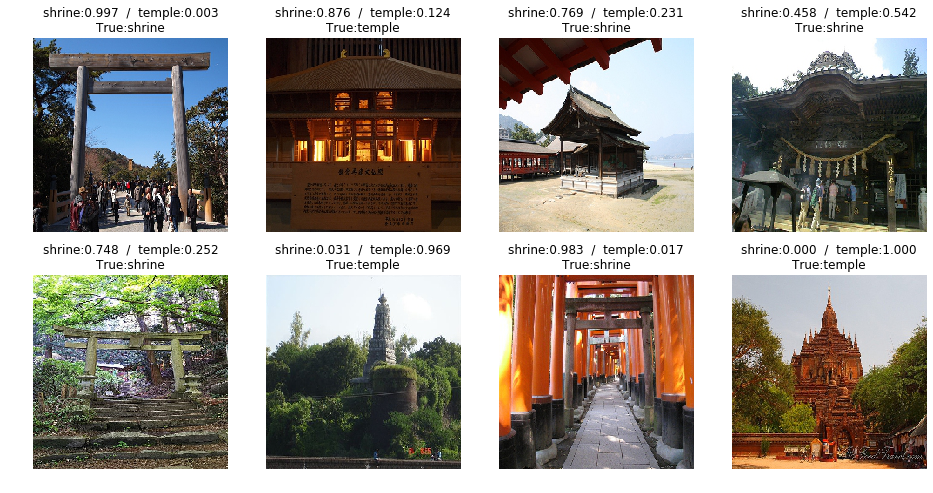

In [37]:
#預測結果

from utils import show_test_samples


show_test_samples(
    x_test, probs, 
    img_itr_train.class_indices, 
    true_labels
)

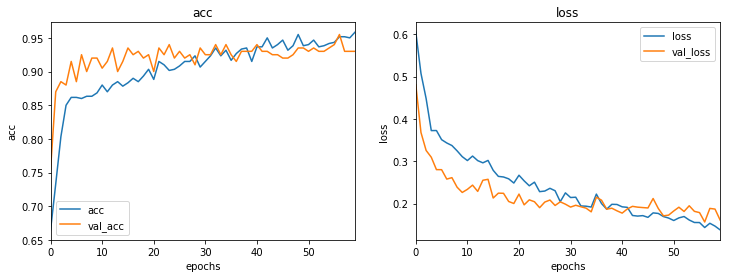

In [38]:
#讀取剛剛callbacks儲存的loss資料

from utils import plot_learningcurve_from_csv


plot_learningcurve_from_csv(csv_filepath)

In [48]:
model

In [52]:
model.save("vgg16-transfer.h5")
print("model saved")


model saved


In [53]:
#讀取模型
#若出現錯誤，這是keras的問題(2.X)
#解決方法: 不要用Sequential方式，換成Functional-API(參考練習: feedforwardnn_functional_api.ipynb)

from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model_new = load_model('vgg16-transfer.h5')

print(model_new)

ValueError: You are trying to load a weight file containing 15 layers into a model with 0 layers

In [81]:
#測試模型是否可以評分

test_data_dir = 'img/shrine_temple/test/unknown'
x_test, true_labels = load_random_imgs(
    test_data_dir, 
    seed=1
)
x_test_preproc= preprocess_input(x_test.copy())/255.
probs = model_new.predict(x_test_preproc)

probs

array([[0.4994125 ],
       [0.49949995],
       [0.49992472],
       [0.49945244],
       [0.49925402],
       [0.500138  ],
       [0.49995413],
       [0.49999282]], dtype=float32)